# Вебинар 6. Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

In [3]:
data = data[~data['user_id'].isin(['296', '1813', '1984', '2498'])]

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
?prefilter_items

In [6]:
# n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

# n_items_after = data_train_lvl_1['item_id'].nunique()
# print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Prefilter success: Decreased number of items from 83680 to 5001


In [7]:
%%time

recommender = MainRecommender(data_train_lvl_1)


Wall time: 5.87 s


In [8]:
# recommender.get_als_recommendations(2375, N=5)

In [9]:
# recommender.get_own_recommendations(2375, N=5)

In [10]:
# recommender.get_similar_items_recommendation(2375, N=5)

In [11]:
# recommender.get_similar_users_recommendation(2375, N=5)

In [12]:
user = 2375
pd.DataFrame({
    'get_als_recommendations': [recommender.get_als_recommendations(user, N=5)],
    'get_own_recommendations': [recommender.get_own_recommendations(user, N=5)],
    'get_similar_items_morecommendation': [recommender.get_similar_items_recommendation(user, N=5)],
    'get_similar_users_recommendation': [recommender.get_similar_users_recommendation(user, N=5)]
}).T

,0
get_als_recommendations,"[899624, 1044078, 1106523, 844179, 871756]"
get_own_recommendations,"[948640, 918046, 847962, 907099, 873980]"
get_similar_items_morecommendation,"[1046545, 1044078, 999270, 15778319, 1078652]"
get_similar_users_recommendation,"[820612, 10457044, 1101502, 5574377, 915064]"


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [13]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
result_lvl_1[result_lvl_1.user_id == 2375].T

,2041
user_id,2375
actual,"[835300, 848029, 862714, 896613, 923746, 93246..."


In [15]:
%%time
result_lvl_1['als_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(user=x, N=50))

Wall time: 39.3 s


In [16]:
%%time
result_lvl_1['own_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(user=x, N=50))

Wall time: 17.6 s


In [17]:
%%time
result_lvl_1['similar_items_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(user=x, N=50))

Wall time: 22.7 s


In [18]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""

    popular = data.groupby(by='item_id')['sales_value'].sum().reset_index()
    popular.sort_values(by='sales_value', ascending=False, inplace=True)

    recs = popular.head(n).item_id

    return recs.tolist()

In [19]:
%%time
result_lvl_1['top-popular'] = result_lvl_1['user_id'].apply(lambda x: popularity_recommendation(data_train_lvl_1, n=50))

Wall time: 1min 50s


In [20]:
result_lvl_1['own+top'] = result_lvl_1['own_rec-s'] + result_lvl_1['top-popular']

In [21]:
result_lvl_1[result_lvl_1.user_id == 2375].T

,2041
user_id,2375
actual,"[835300, 848029, 862714, 896613, 923746, 93246..."
als_rec-s,"[899624, 1044078, 1106523, 844179, 871756, 883..."
own_rec-s,"[948640, 918046, 847962, 907099, 873980, 88469..."
similar_items_rec-s,"[1046545, 1044078, 999270, 15778319, 1078652, ..."
top-popular,"[999999, 1029743, 916122, 5569230, 1106523, 84..."
own+top,"[948640, 918046, 847962, 907099, 873980, 88469..."


In [22]:
def score_recomends(result_df):
    import pandas as pd
    from src.metrics import precision_at_k, recall_at_k
    df = pd.DataFrame(
        [
            (model_,
             round(result_df.apply(lambda row: precision_at_k(recommended_list=row[str(model_)], bought_list=row['actual']), axis=1).mean(), 5),
             round(result_df.apply(lambda row: recall_at_k(recommended_list=row[str(model_)], bought_list=row['actual']), axis=1).mean(), 5),
             ) for model_ in list(result_df)[2:]
        ], columns=['model', 'precision_at_k', 'recall_at_k']
    ).sort_values(by='precision_at_k', ascending=False)

    return df

In [23]:
score_recomends(result_df=result_lvl_1)

,model,precision_at_k,recall_at_k
1,own_rec-s,0.17721,0.01829
4,own+top,0.17721,0.01829
0,als_rec-s,0.11628,0.01276
3,top-popular,0.11284,0.01363
2,similar_items_rec-s,0.06074,0.00593


B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [24]:
result_lvl_1_var_2 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

In [25]:
result_lvl_1_var_2.head(2).T

,0,1
user_id,1,2
actual,"[853529, 865456, 867607, 872137, 874905, 87524...","[15830248, 838136, 839656, 861272, 866211, 870..."


In [26]:
%%time
for k in [20, 50, 100, 200, 500, 750, 1000, 1500]:
    print(f'k={k}')
    result_lvl_1_var_2[f'similar_items_k={k}'] = \
        result_lvl_1_var_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(user=x, N=k))

k=20
k=50
k=100
k=200
k=500
k=750
k=1000
k=1500
Wall time: 5min 38s


In [27]:
result_lvl_1_var_2.head(1).T

,0
user_id,1
actual,"[853529, 865456, 867607, 872137, 874905, 87524..."
similar_items_k=20,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=50,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=100,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=200,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=500,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=750,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=1000,"[824758, 1007512, 9297615, 5577022, 920200, 10..."
similar_items_k=1500,"[824758, 1007512, 9297615, 5577022, 920200, 10..."


In [56]:
k=750
result_lvl_1_var_2.apply(
    lambda row: recall_at_k(recommended_list=row[f'similar_items_k={k}'], bought_list=row['actual'], k=k), axis=1
).mean()

0.15941199256119334

In [54]:
recals_at_list_k = pd.DataFrame(
    [
        (
            k, 
            result_lvl_1_var_2.apply(
                lambda row: recall_at_k(
                    recommended_list=row[f'similar_items_k={k}'], bought_list=row['actual'], k=k), axis=1).mean()
        ) for k in [20, 50, 100, 200, 500, 750, 1000, 1500]
        
    ], columns={'k', 'value'}).sort_values(by='value', ascending=False)

recals_at_list_k

,k,value
7,1500,0.211997
6,1000,0.181552
5,750,0.159412
4,500,0.135400
3,200,0.085107
2,100,0.053088
1,50,0.033698
0,20,0.017959


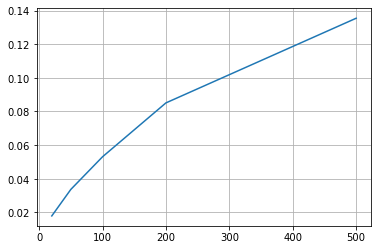

In [30]:
plt.plot(recals_at_list_k['k'],
         recals_at_list_k['value'])
plt.grid();

In [55]:
recals_at_list_k.head(1)

,k,value
7,1500,0.211997


C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

recall при k=1500 показал наибольшее значениe

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [32]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

#создание списков кандидатов на певом уровне
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))

#разворачивание списков в столбцы
df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values).astype('int64')})

In [33]:
#создание таргета на основе полученных на первом уровне кандидатов и совпадения их с валидационным датасетом для первого уровня
targets_lvl_2 = data_train_lvl_2.drop_duplicates(['user_id', 'item_id'])[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2['target'].mean()

0.0303153488372093

In [34]:
# заменим бренд СТМ на 1, остальное на 0
item_features['brand'] = item_features['brand'].map({'National': 0, 'Private': 1})

In [35]:
# Заменимм возраст по нижней границе
user_features['age_desc'] = user_features['age_desc'].map({'45-54': 45, '35-44': 35, '55-64': 55, '25-34': 25, '65+': 65, '19-24': 19})

# Заменимм доход по нижней границе
user_features['income_desc'] = user_features['income_desc'].map({
    '50-74K': 50000, '35-49K': 35000, '75-99K': 75000, '25-34K': 25000, '15-24K': 15000, 'Under 15K': 0, 
    '125-149K': 125000, '100-124K': 100000, '150-174K': 150000, '250K+': 250000, '175-199K': 175, 
    '200-249K': 200000})
# Заменим в кол-ве детей 3+ на 3
user_features['kid_category_desc'] = user_features['kid_category_desc'].map({'None/Unknown': 0, '3+': 3})

# Заменим собственость на "вероятность владения домом"
user_features['homeowner_desc'] = user_features['homeowner_desc'].map({'Homeowner': 1, 'Unknown': 0, 'Renter': 0, 
                                    'Probable Owner': 0.75, 'Probable Renter': 0.25})
#  Заменим в размере дома 5+ на 5
user_features['household_size_desc'] = user_features['household_size_desc'].map({'5+': 5})

In [36]:
# Добавим средний чек
user_features = user_features.merge(right = user_features.merge(right=data, on='user_id', how='left') \
                                    .groupby(by='user_id')['sales_value'].mean() \
                                    .reset_index().rename(columns={'sales_value': 'average_purchase'}),
                                    on='user_id', how='left')

In [37]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [38]:
X_train = targets_lvl_2.drop(['user_id', 'item_id', 'target'], axis=1)
y_train = targets_lvl_2['target']

In [39]:
X_train

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_purchase
0,69,DELI,1,SANDWICHES,SANDWICHES - (COLD),,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
1,2468,GROCERY,0,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
2,69,DRUG GM,1,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
3,1213,DRUG GM,0,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
4,69,DRUG GM,1,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074995,1126,GROCERY,0,CHEESE,STRING CHEESE,12 OZ,45.0,A,0.0,0.0,Single Male,NaN,0.0,2.682708
1074996,1646,PRODUCE,0,SALAD MIX,KITS,10 OZ,45.0,A,0.0,0.0,Single Male,NaN,0.0,2.682708
1074997,35,DRUG GM,0,MAGAZINE,TABLOIDS-MAGAZINE,,45.0,A,0.0,0.0,Single Male,NaN,0.0,2.682708
1074998,69,GROCERY,1,CHEESE,SHREDDED CHEESE,6 OZ,45.0,A,0.0,0.0,Single Male,NaN,0.0,2.682708


In [40]:
# cat_feats = X_train.columns[1:].tolist()
cat_feats = ['department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'marital_status_code', 'hh_comp_desc']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [41]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(categorical_column=['department', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'marital_status_code', 'hh_comp_desc'],
               max_depth=7, objective='binary')

In [42]:
train_preds = lgb.predict_proba(X_train)[:, 1]

In [43]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique() \
            .reset_index().rename(columns={'item_id': 'actual'})

In [44]:
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [45]:
temp_result = targets_lvl_2.loc[:, ['user_id', 'item_id']]

In [46]:
#добавление неотсортированных кандидатов
candidats = temp_result.groupby('user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(candidats, on=['user_id'], how='left').rename(columns={'item_id': 'own_recs'})

In [47]:
#добавление отсортированных по LGBMClassifier кандидатов
temp_result['train_preds'] = train_preds
temp_result.sort_values('train_preds', ascending=False, inplace=True)

top_candidats = temp_result.groupby(by='user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(right=top_candidats, on=['user_id'], how='left')
result_lvl_2 = result_lvl_2.rename(columns={'item_id': 'lgbm_recs'})

In [48]:
result_lvl_2.head(3)

,user_id,actual,own_recs,lgbm_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1082185, 8293439, 9655212, 1068719, 1106523, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN,NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1082185, 1082185, 845208, 900802, 1029743, 10..."


In [49]:
result_lvl_2.loc[result_lvl_2['lgbm_recs'].isnull()]

,user_id,actual,own_recs,lgbm_recs
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN,NaN
37,48,"[857000, 890533, 960718, 971585, 979178, 99606...",NaN,NaN
46,60,"[15512234, 17105530]",NaN,NaN
56,73,"[1069003, 1071939, 1110764, 1130581, 829291, 8...",NaN,NaN
72,89,"[878910, 956995, 1055863, 9879409, 12781501]",NaN,NaN
...,...,...,...,...
1941,2373,"[853262, 859075, 873203, 883404, 908940, 10297...",NaN,NaN
1950,2383,"[973016, 10198378, 15512234, 17105530, 948953]",NaN,NaN
1961,2399,"[820582, 835098, 938700, 947858, 1013321, 1030...",NaN,NaN
2029,2487,"[862407, 1099089, 1135834, 5570383, 10344585, ...",NaN,NaN


In [50]:
result_lvl_2 = result_lvl_2.drop(np.where(result_lvl_2['lgbm_recs'].isnull())[0], axis=0)

In [51]:
result_lvl_2

,user_id,actual,own_recs,lgbm_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1082185, 8293439, 9655212, 1068719, 1106523, ..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1082185, 1082185, 845208, 900802, 1029743, 10..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[896666, 998519, 894360, 7147142, 9338009, 939...","[1082185, 1126899, 1106523, 1029743, 1029743, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[12808385, 981660, 939860, 7410201, 5577022, 6...","[1082185, 1126899, 1106523, 1029743, 1070820, ..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[872146, 918046, 9655676, 985622, 1056005, 801...","[1082185, 1070820, 1126899, 1106523, 1029743, ..."
...,...,...,...,...
2034,2494,"[859075, 1053598, 1071939, 5568729, 9553191, 1...","[1117219, 7024847, 1115800, 1003524, 8090508, ...","[1082185, 1070820, 1106523, 1029743, 1029743, ..."
2036,2496,[6534178],"[872826, 983665, 991546, 1134296, 7441210, 974...","[1082185, 1126899, 1070820, 1029743, 1106523, ..."
2037,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[870515, 1117219, 1102207, 1057168, 1135834, 1...","[1082185, 1082185, 870515, 1117514, 900802, 10..."
2038,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[7168055, 1128395, 6904613, 5570048, 889989, 8...","[1082185, 1044078, 1044078, 1070820, 1029743, ..."


In [52]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_recs'], row['actual']), axis=1).mean()

0.16332288401253703

In [53]:
result_lvl_2.apply(lambda row: precision_at_k(row['own_recs'], row['own_recs']), axis=1).mean()

1.0277951933124385

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 